1. Qual a frequência dos valores da variável X de maneira global? E quando correlacionada à classe A? Podemos atribuir essa frequência a uma distribuição conhecida (normal, linear, uniforme, etc)?
2. Qual a correlação entre as variáveis X e Y? É linear crescente, descrescente? Não existe relação?
3. Quantas são as ocorrências de valores faltantes entre os dados? Em quais classes essas ocorrências são mais expressivas e menos expressivas?
4. Qual a dispersão das variável X? Essa variação muda se observarmos X apenas em função da classe A?
5. Quais variáveis mudam mais quando se muda a classe observada? Quais variáveis não?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
df_le = pd.read_csv('si_gc_left_eye.csv', index_col=0)
df_re = pd.read_csv('si_gc_right_eye.csv', index_col=0)

Essa nuvem quando colocado os valores de curvatura gaussiana = 0.005 e shape index = -0.85, o algoritmo encontra o canto interno direito do olho. O que ela tem de especial??

Como mostrado em uma análise mais abaixo: ela pertence a um conjunto de nuvens onde o shape index se concentra entre -0.9 e -0.8. E a curvatura com valores bem próximos de 0.005.

In [3]:
df_le.iloc[40]

cloud           bs000_E_ANGER_0.pcd
individuo                         0
radius_10_si               -0.85091
radius_10_cg               0.004594
radius_11_si              -0.859452
radius_11_cf               0.004508
radius_12_si              -0.867032
radius_12_cg               0.004385
radius_13_si              -0.857345
radius_13_cg               0.004091
radius_14_si              -0.829545
radius_14_cg               0.003642
k_100_si                  -0.737684
k_100_cg                   0.003005
k_150_si                  -0.780207
k_150_cg                   0.003748
k_200_si                   -0.80677
k_200_cg                   0.004364
k_250_si                  -0.819825
k_250_cg                   0.004552
k_300_si                  -0.823293
k_300_cg                   0.004544
type                              E
expression                    ANGER
Name: 40, dtype: object

In [4]:
columns = df_le.columns[2:-2].values # only shape index and gaussian curvature column values

## Correlation Matrix

In [5]:
def correlation_matrix(df, title):
    corr = df[columns].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, annot=True, cmap=sns.cm.rocket_r)
    plt.title(title)
    plt.show()

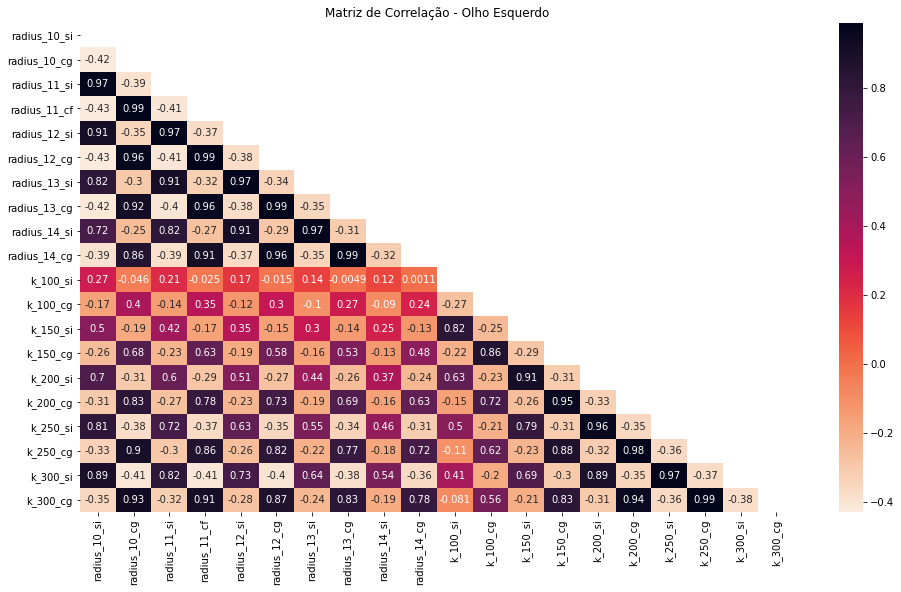

In [6]:
correlation_matrix(df_le, 'Matriz de Correlação - Olho Esquerdo')

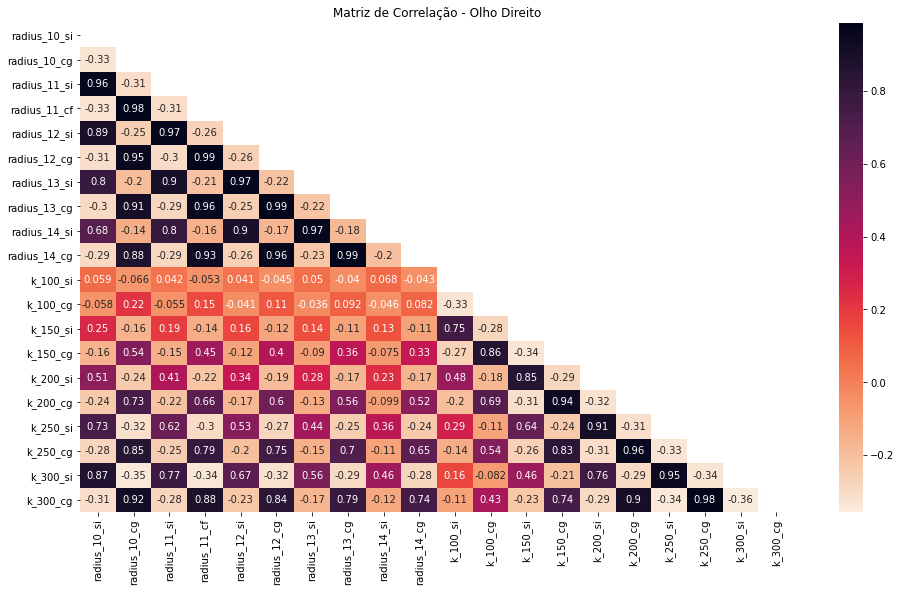

In [7]:
correlation_matrix(df_re, 'Matriz de Correlação - Olho Direito')

In [8]:
# plot_histograms is a function that plot subplots of histograms based on expression. If expression
# is None, the complete dataframe will be used.
def plot_histograms(df, expression=None):
    nrows, ncols = 4, 5 
    fig, axes = plt.subplots(nrows, ncols)
    fig.tight_layout()
    
    if expression is not None:
        df = df.loc[df['expression'] == expression]

    i, j = 0, 0 # refactor
    for index, column in enumerate(columns):
        df.hist(ax=axes[i, j], column=[column], bins=10) # What is the better bins to use? 10 is default.
        j += 1
        if j == 5:
            i += 1
            j = 0

    plt.show()

## Global Frequency

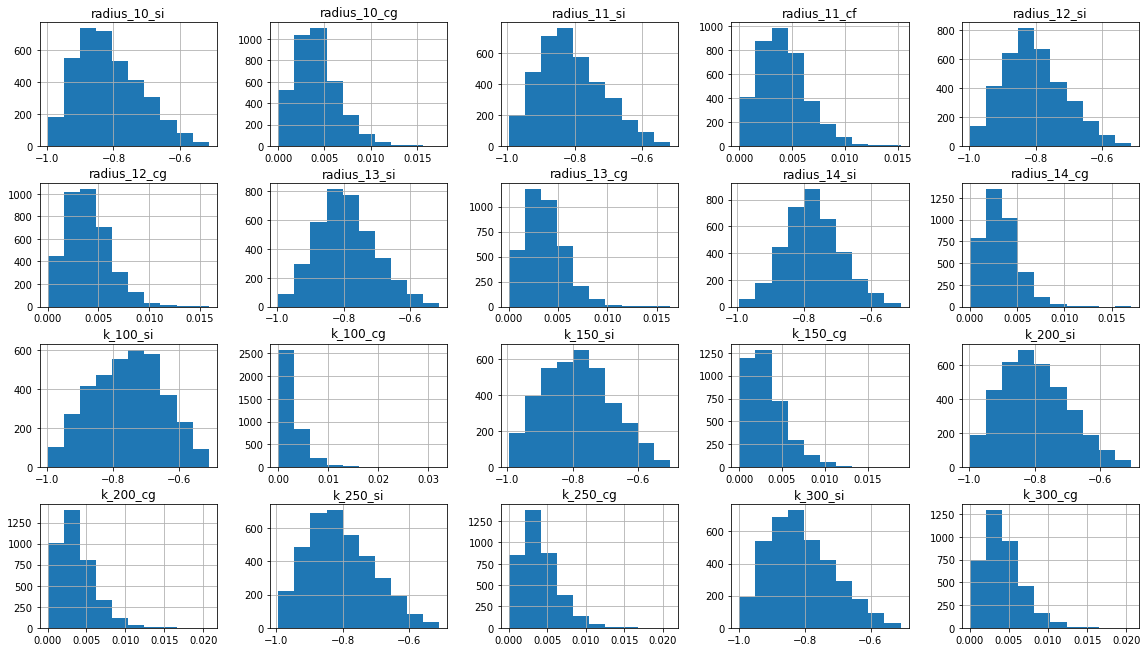

In [9]:
plot_histograms(df_le)

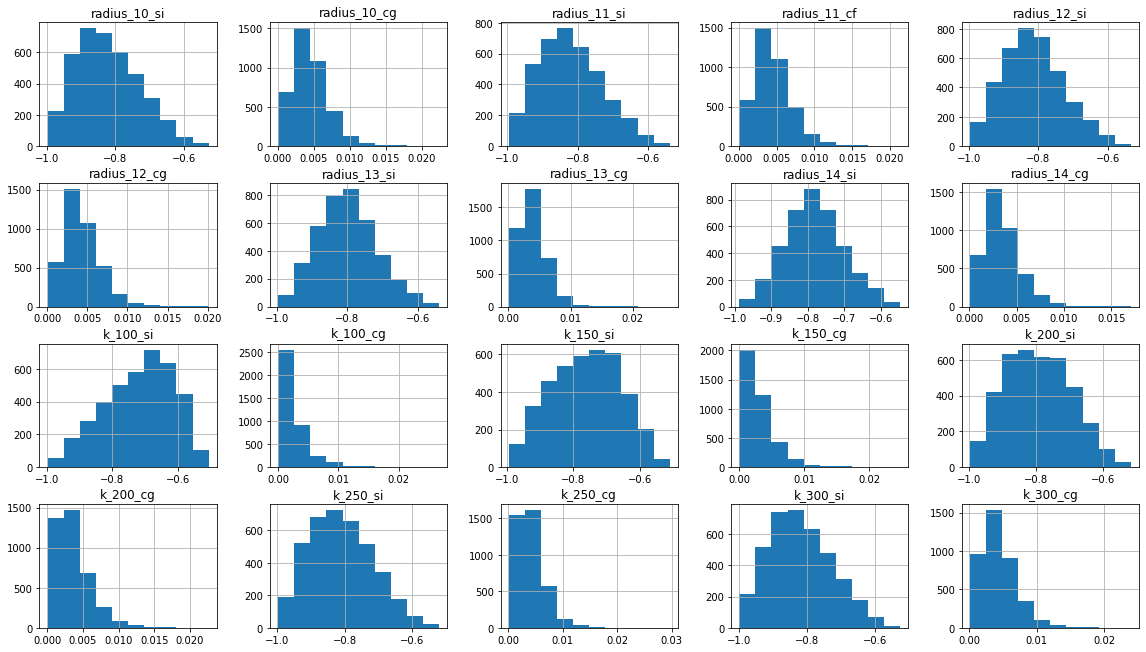

In [10]:
plot_histograms(df_re)

Observações:

1. Podemos perceber que na maioria dos gráficos o shape index pode variar entre -1 e -0.5, enquanto que a curvatura pode variar entre 0.000 e 0.005 (valores muito pequenos).
2. Com essa informação, eu brinquei um pouco na ferramenta 3D e obtive uma experiência bem legal. Quando coloco esses valores, antes de ele encontrar a ponta do nariz, ele passa por regiões perto dos olhos. Vou deixar dois prints abaixo mostrando os resultados.

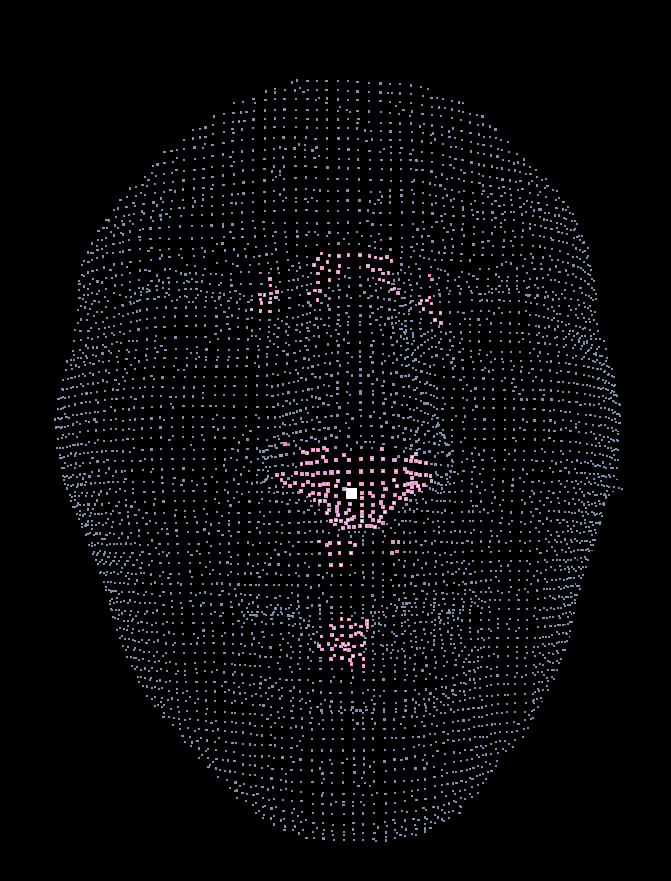

Enquanto que em outra nuvem: bs000_E_ANGER_0.pcd ele já encontra o canto do olho direito. :D

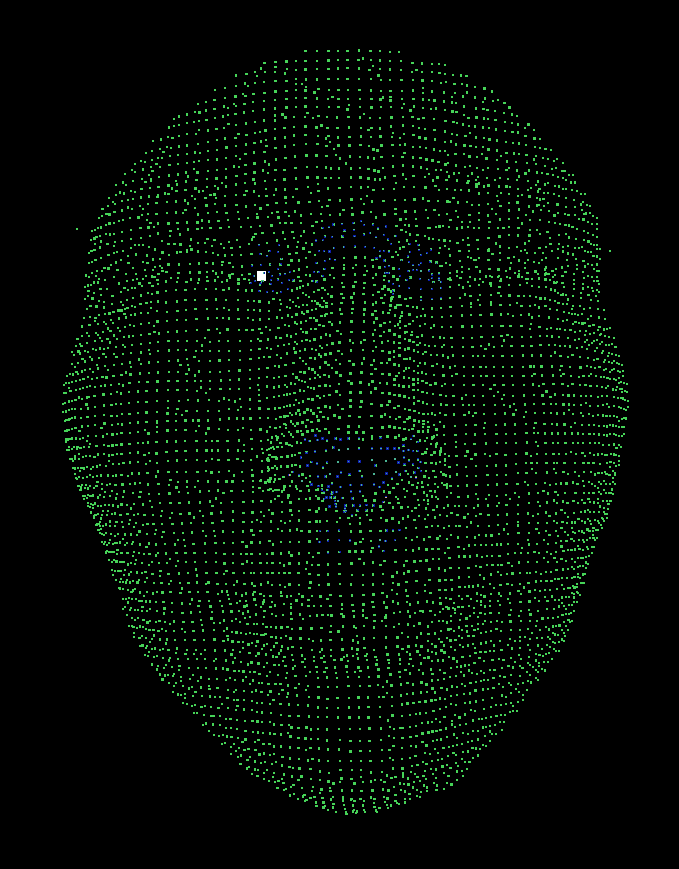

Ps: Essa nuvem está pré-processada. Quando testado na nuvem original o resultado é esse:

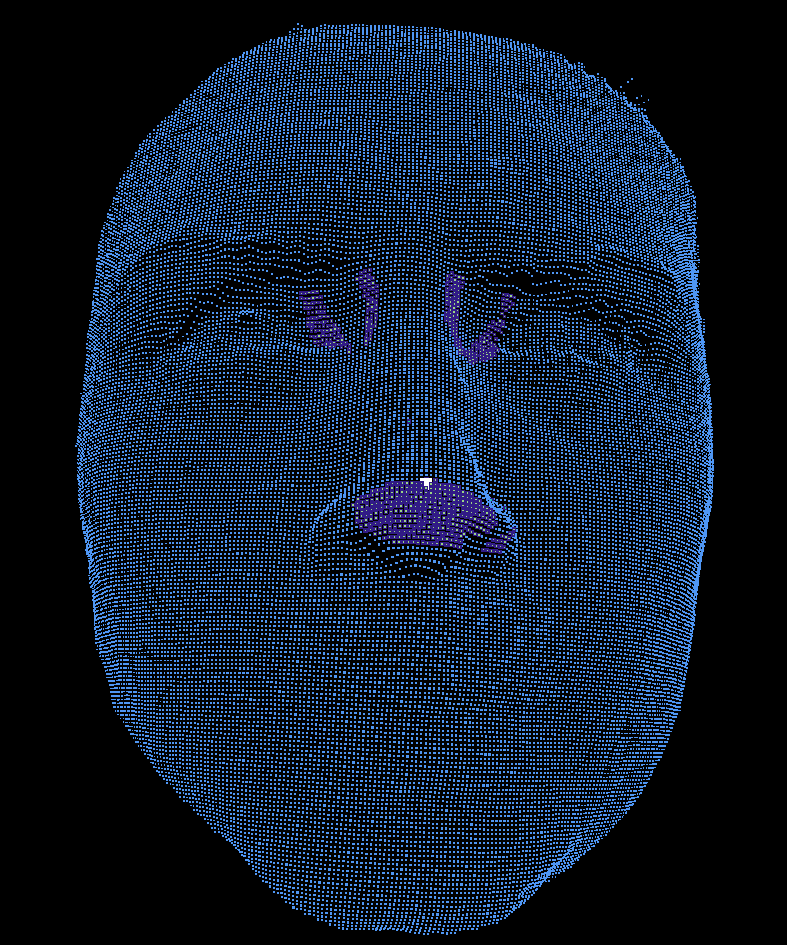

Ok, isso é ótimo!!

Como o algoritmo é para encontrar a ponta do nariz, ele vai um pouco mais além com a filtragem, mas em um algum momento ele passa por essa região. Precisamos descobrir que região é essa.

Estou tendo um pouco de dificuldades para encontrar essa região porque ainda estou tentando entender melhor a implementação do algoritmo.

Obs: O algoritmo de encontrar a ponta do nariz é ótimo, até porque mesmo mudando os parâmetros de entrada, ele ainda encontra. Mas com a brilhante mente do desenvolvedor que fez, a gente tem um log dessas nuvens e, portanto, conseguimos ver por onde ele passou. E manualmente rodando esse algoritmo com várias nuven diferentes, é fato que o algoritmo, na maioria das vezes, sempre passa pelra região dos olhos.

In [11]:
# plot_histograms(df_le, expression='A22A25')

In [12]:
# plot_histograms(df_le, expression='ANGER')

In [13]:
# plot_histograms(df, expression='FEAR')

In [14]:
# plot_histograms(df_le, expression='HAPPY')

In [15]:
# plot_histograms(df_le, expression='SURPRISE')

In [16]:
# plot_histograms(df_le, expression='SADNESS')

Baseado em algumas análises dos histogramas, temos algumas informações:

- Valores de shape index e curvatura gaussiana com raio=13 ótimos para expressões ANGER e DISGUST.
  - Shape Index: -0.78
  - Curvatura Gaussiana: 0.0038
  
  Quando eu digo que esses valores são ótimos, é porque durante o processamento do algoritmo, uma grande região de pontos é formada em volta do canto do olho direito e esquerdo.
  
- Como eu ainda estou utilizando o algoritmo do Marcus como base, ele tá levando em consideração algumas métricas/estratégias relacionadas a ponta do nariz. Por exemplo: depois que ele faz a filtragem do crop, ele remove os pontos isolados utilizando a seguinda estratégia:
  - Para cada ponto, dado um raio da ponta do nariz e um numero de threshold como input, ele pega o número de n vizinhos dentro desse raio. E no final, o nosetip é escolhido escolhendo aquele ponto com o maior número de vizinhos. Mas ele só leva em consideração o maior número de pontos, se for igual, ele não substitui o nosetip escolhido. Coloando essa pequena modificação no algoritmo (>=), ele começa a escolher outros pontos aleatorios (mas coincidentemente alguns dos pontos foram: canto interno do olho esquerdo, canto esquerdo e direito da boca).
    
    Existe uma outra estratégia para isso?
    
    - Comecei a análisar os valores de anisotropia, será que eles nos dizem algo?

TODO:

[x] Refrescar mais um pouco na memória o TCC do Marcus.

[x] Refrescar mais um pouco o artigo que eu estava lendo anteriormente.

### Plot only one histogram for better visualization

In [17]:
def plot_histogram(df, column):
    df.hist(column=column, bins=10)
    plt.show()

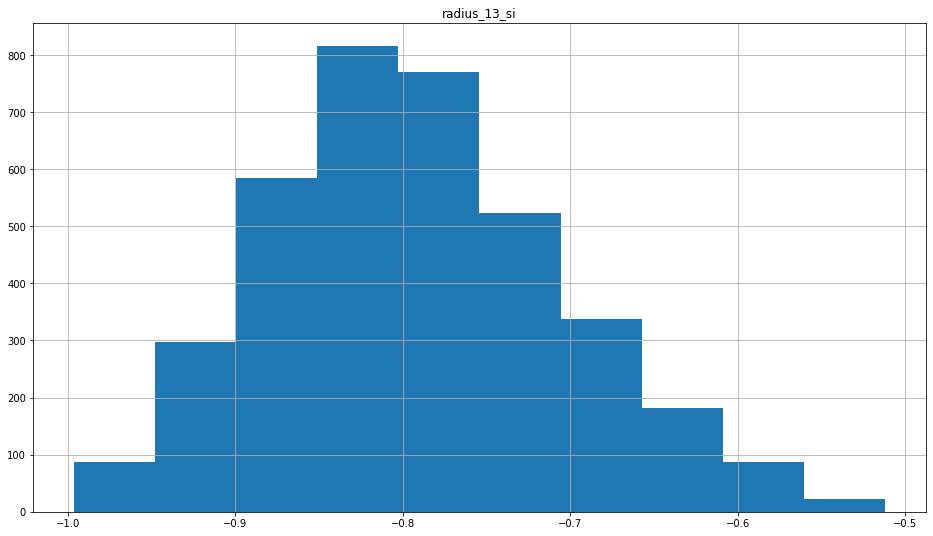

In [18]:
plot_histogram(df_le, 'radius_13_si')

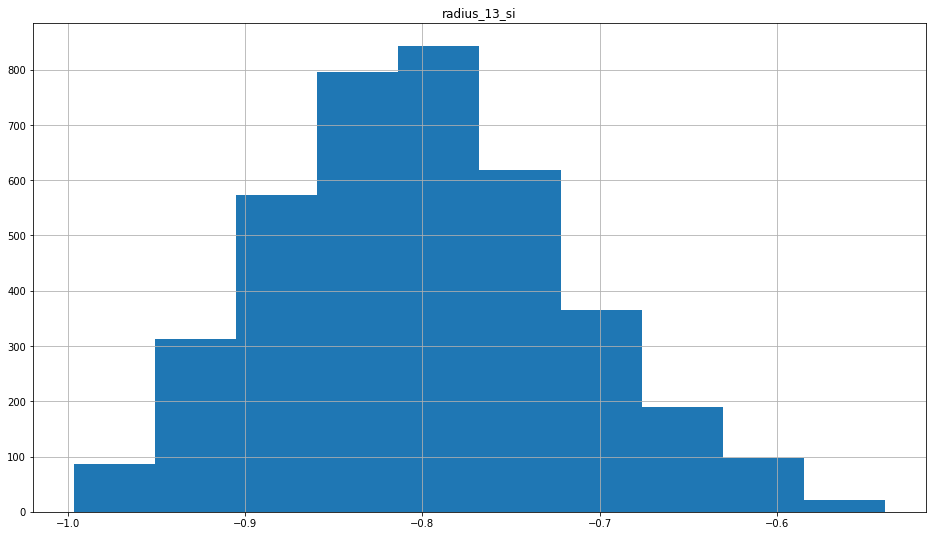

In [19]:
plot_histogram(df_re, 'radius_13_si')

## Null values

Number of null values in the dataset. If there is a null value in one column, all other columns will also have null values. So this operation below shows how many null rows we have.

In [20]:
df_le['radius_10_si'].isna().sum()

958

In [21]:
df_re['radius_10_si'].isna().sum()

763

But how many null lines are there for each class?

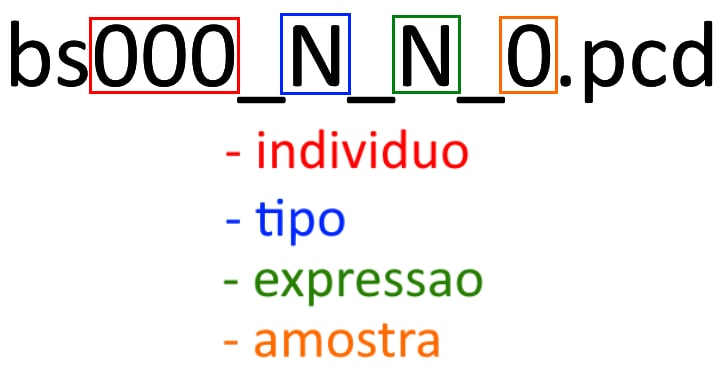

http://bosphorus.ee.boun.edu.tr/Content.aspx

In [22]:
# TODO: Are these expressions right? I'll check the bosphorus documentation. (YES)

# expressions = df_le['expression'].unique()

# for expression in expressions:
#     total = df_le['radius_10_si'].loc[df_le['expression'] == expression].isna().sum()
#     print(f'Expression: {expression} - {total}')

## Variâncias

In [23]:
def plot_variances(df):
    variances = df[columns].var()
    print('Variâncias:')
    print(variances)
    print('Maior variância: ', variances.idxmax())
    print('Menor variância: ', variances.idxmin())
    
    plt.plot(range(len(variances)), variances.values)
    plt.xlabel('X')
    plt.ylabel('Variâncias')
    plt.show()

Variâncias:
radius_10_si    0.009342
radius_10_cg    0.000005
radius_11_si    0.008948
radius_11_cf    0.000005
radius_12_si    0.008344
radius_12_cg    0.000005
radius_13_si    0.007661
radius_13_cg    0.000004
radius_14_si    0.006914
radius_14_cg    0.000003
k_100_si        0.011268
k_100_cg        0.000006
k_150_si        0.010619
k_150_cg        0.000005
k_200_si        0.009906
k_200_cg        0.000006
k_250_si        0.009732
k_250_cg        0.000006
k_300_si        0.009610
k_300_cg        0.000006
dtype: float64
Maior variância:  k_100_si
Menor variância:  radius_14_cg


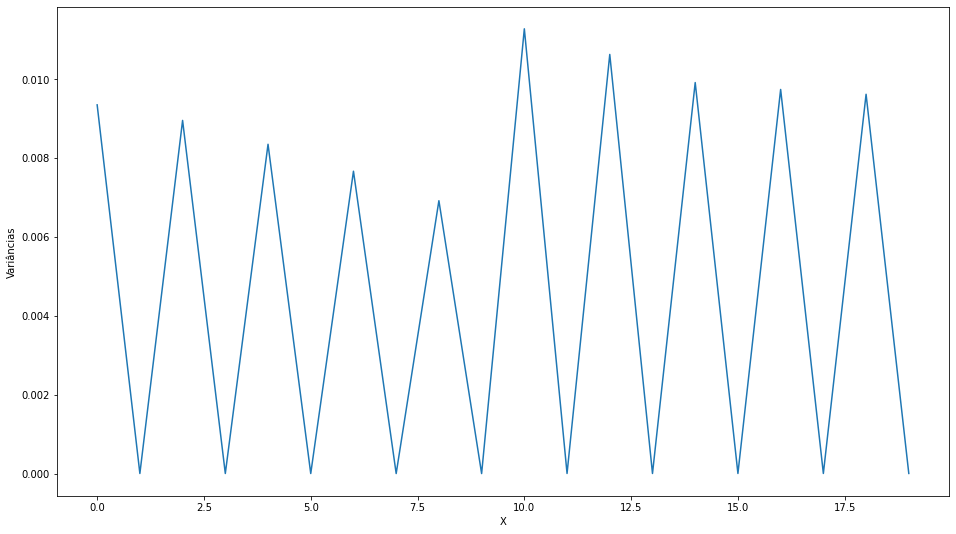

In [24]:
plot_variances(df_le)

Variâncias:
radius_10_si    0.008210
radius_10_cg    0.000006
radius_11_si    0.007853
radius_11_cf    0.000006
radius_12_si    0.007449
radius_12_cg    0.000005
radius_13_si    0.006878
radius_13_cg    0.000005
radius_14_si    0.006345
radius_14_cg    0.000004
k_100_si        0.010802
k_100_cg        0.000008
k_150_si        0.010593
k_150_cg        0.000006
k_200_si        0.009344
k_200_cg        0.000006
k_250_si        0.008617
k_250_cg        0.000007
k_300_si        0.008332
k_300_cg        0.000007
dtype: float64
Maior variância:  k_100_si
Menor variância:  radius_14_cg


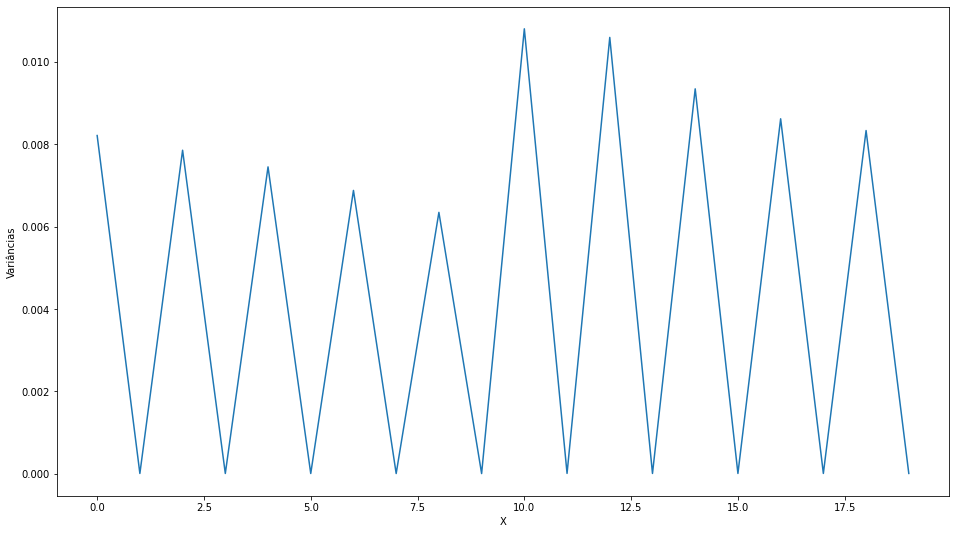

In [25]:
plot_variances(df_re)

## Médias

In [26]:
def plot_means(df):
    means = df[columns].mean()
    print('Médias:')
    print(means)
    print('Maior média: ', means.idxmax())
    print('Menor média: ', means.idxmin())
    
    plt.plot(range(len(means)), means.values)
    plt.xlabel('X')
    plt.ylabel('Médias')
    plt.show()

Médias:
radius_10_si   -0.813657
radius_10_cg    0.004197
radius_11_si   -0.810888
radius_11_cf    0.004153
radius_12_si   -0.804067
radius_12_cg    0.003970
radius_13_si   -0.791695
radius_13_cg    0.003666
radius_14_si   -0.773933
radius_14_cg    0.003272
k_100_si       -0.755051
k_100_cg        0.002765
k_150_si       -0.785965
k_150_cg        0.003280
k_200_si       -0.798748
k_200_cg        0.003690
k_250_si       -0.806272
k_250_cg        0.003997
k_300_si       -0.810751
k_300_cg        0.004215
dtype: float64
Maior média:  k_300_cg
Menor média:  radius_10_si


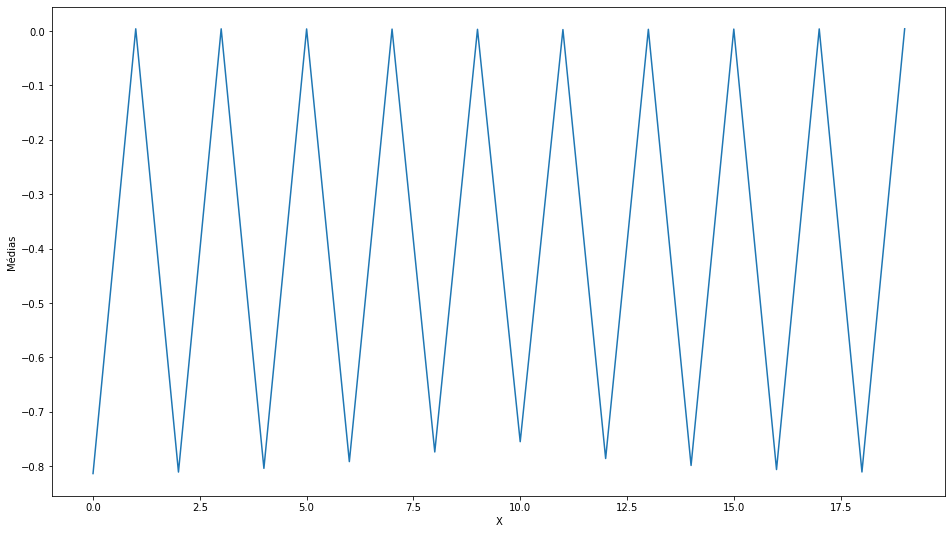

In [27]:
plot_means(df_le)

Médias:
radius_10_si   -0.822474
radius_10_cg    0.004534
radius_11_si   -0.820322
radius_11_cf    0.004480
radius_12_si   -0.813277
radius_12_cg    0.004266
radius_13_si   -0.800247
radius_13_cg    0.003927
radius_14_si   -0.782319
radius_14_cg    0.003490
k_100_si       -0.718849
k_100_cg        0.002656
k_150_si       -0.762889
k_150_cg        0.003065
k_200_si       -0.793945
k_200_cg        0.003615
k_250_si       -0.809659
k_250_cg        0.004070
k_300_si       -0.817504
k_300_cg        0.004390
dtype: float64
Maior média:  radius_10_cg
Menor média:  radius_10_si


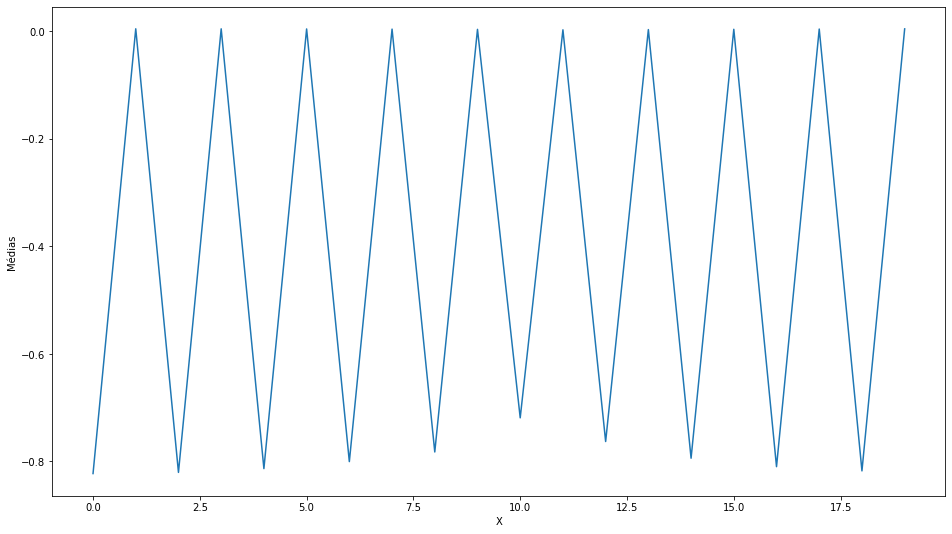

In [28]:
plot_means(df_re)

In [29]:
def plot_scatterplot(df, column, expression=None):
    nrows, ncols = 4, 5 
    fig, axes = plt.subplots(nrows, ncols)
    fig.tight_layout()
    
    if expression is not None:
        df = df.loc[df['expression'] == expression]

    i, j = 0, 0 # refactor
    for index, col in enumerate(columns):
        df.plot.scatter(ax=axes[i, j], x=column, y=col)
        j += 1
        if j == 5:
            i += 1
            j = 0

    plt.show()

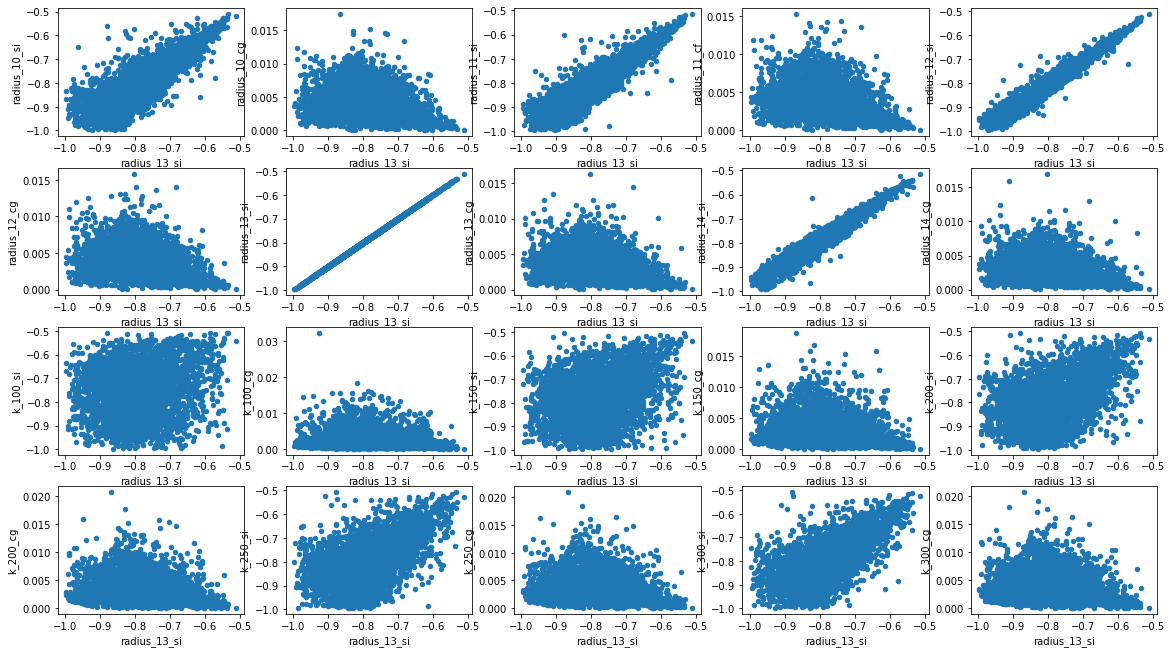

In [30]:
plot_scatterplot(df_le, 'radius_13_si')

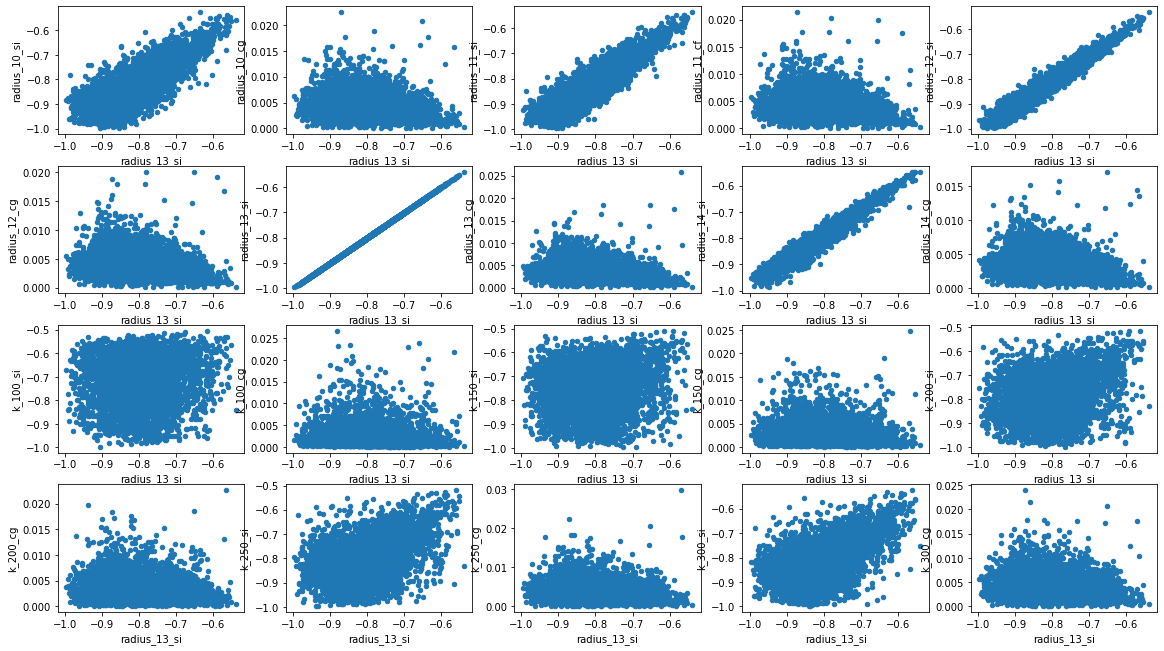

In [31]:
plot_scatterplot(df_re, 'radius_13_si')

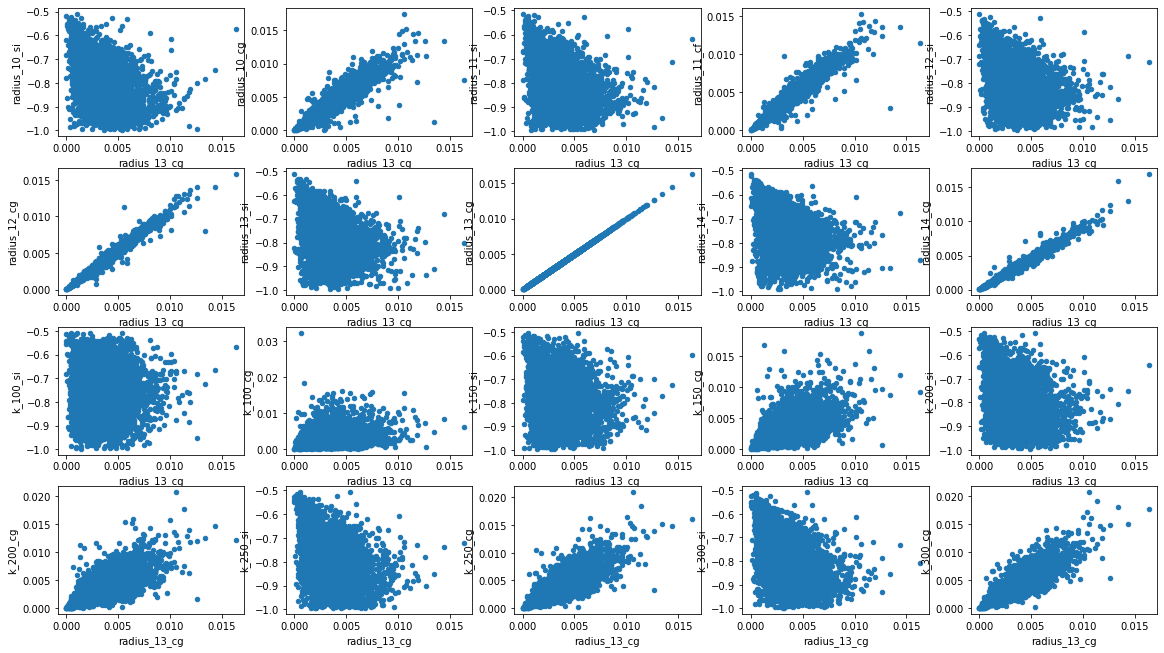

In [32]:
plot_scatterplot(df_le, 'radius_13_cg')

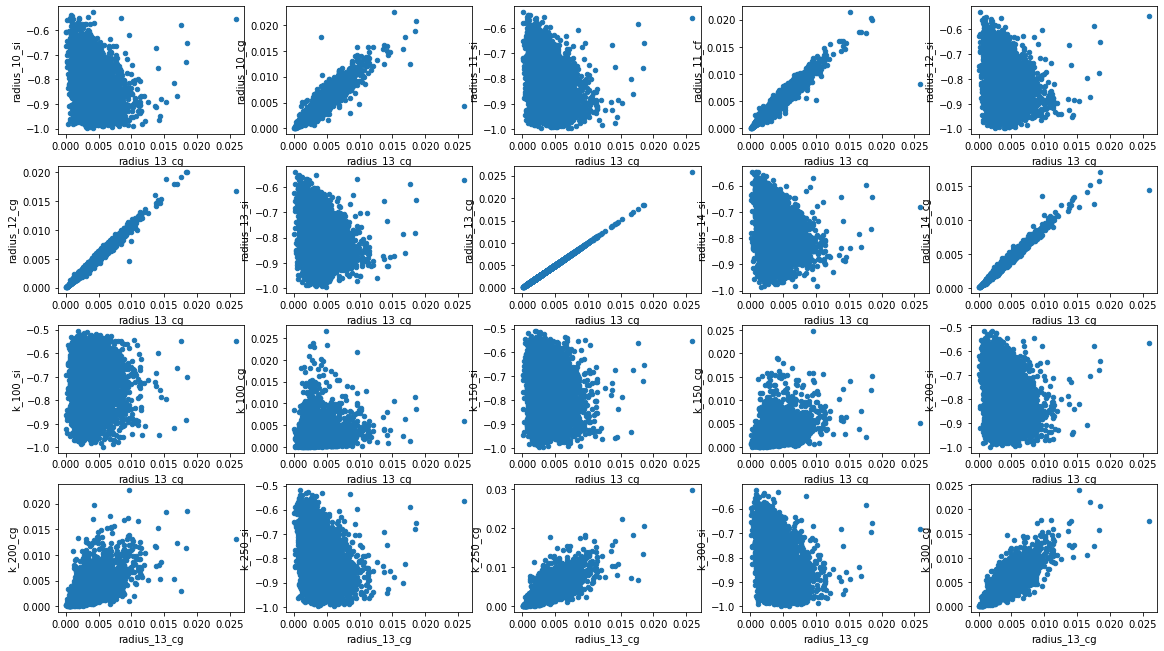

In [33]:
plot_scatterplot(df_re, 'radius_13_cg')

In [34]:
def plot_boxplots(df):
    nrows, ncols = 4, 5 
    fig, axes = plt.subplots(nrows, ncols)
    fig.tight_layout()

    i, j = 0, 0 # refactor
    for index, col in enumerate(columns):
        df.boxplot(column=col, ax=axes[i, j])
        j += 1
        if j == 5:
            i += 1
            j = 0

    plt.show()

def plot_boxplot(df, column):
    df.boxplot(column=column)
    plt.show()

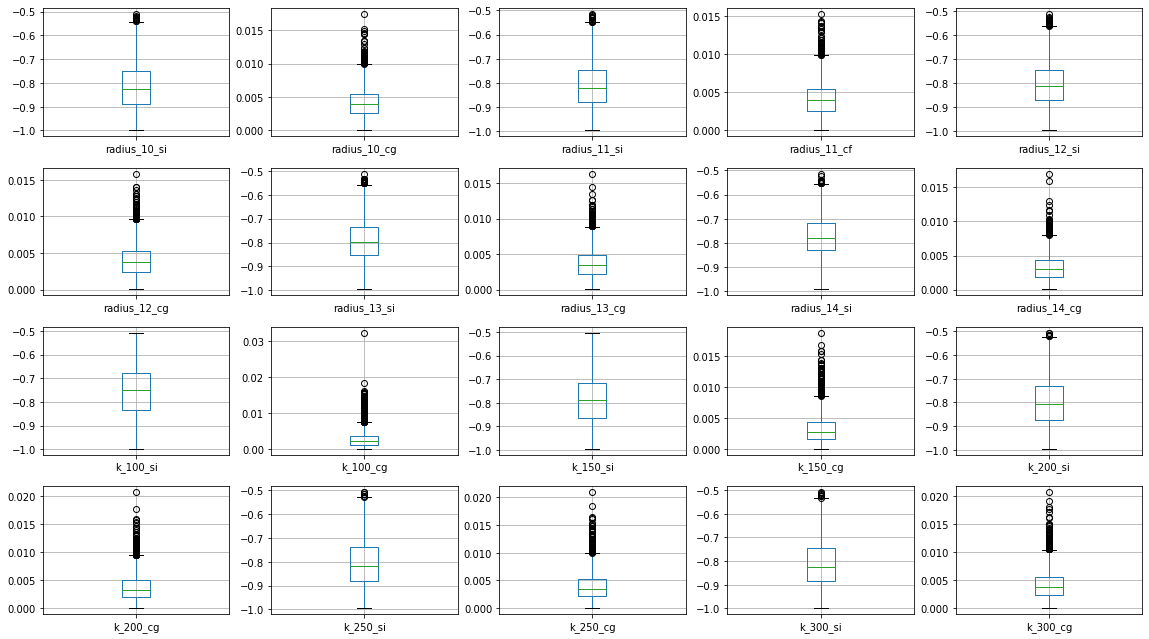

In [35]:
plot_boxplots(df_le)

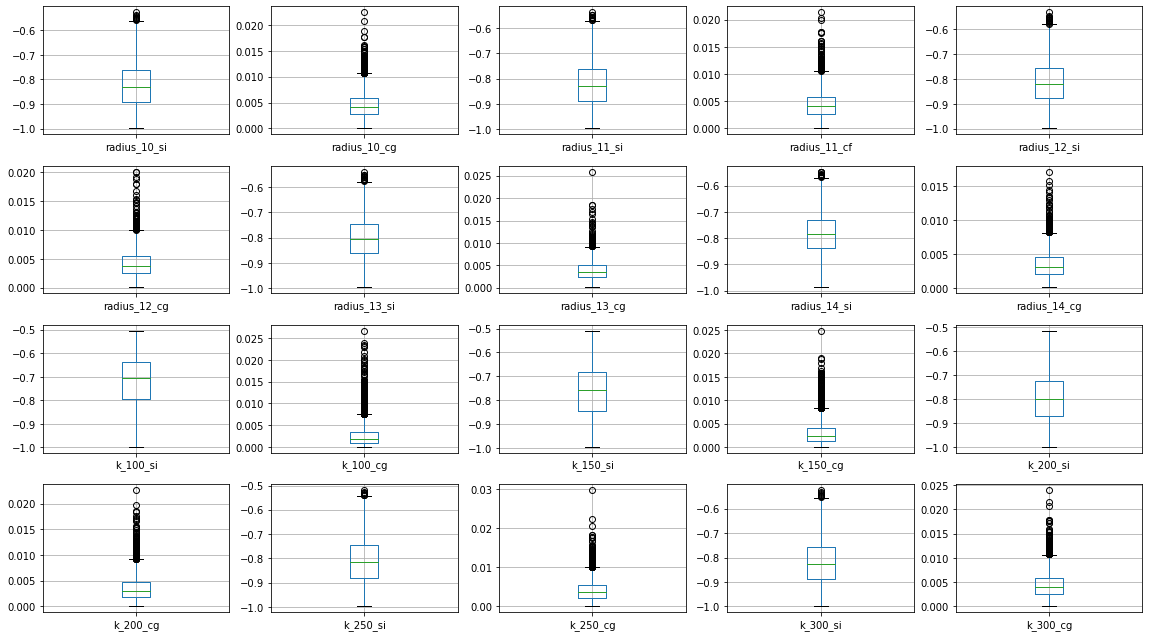

In [36]:
plot_boxplots(df_re)

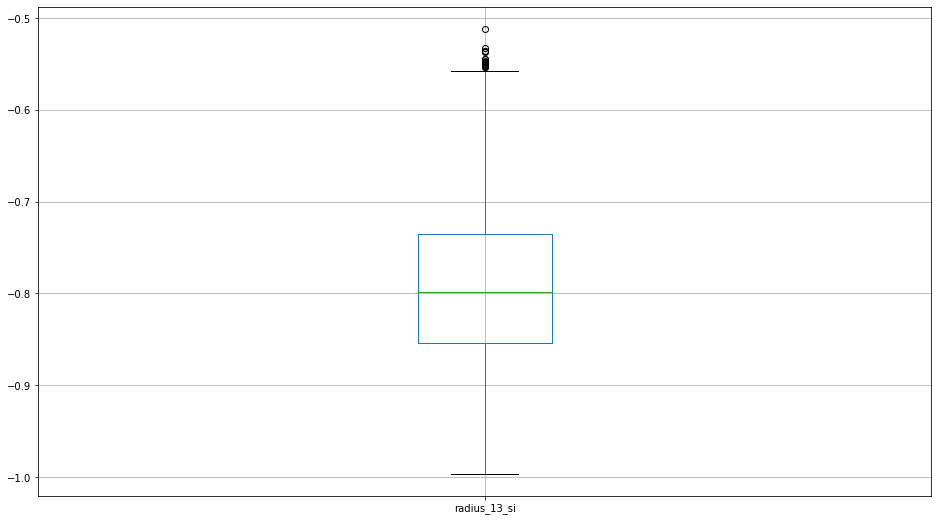

In [37]:
plot_boxplot(df_le, 'radius_13_si')

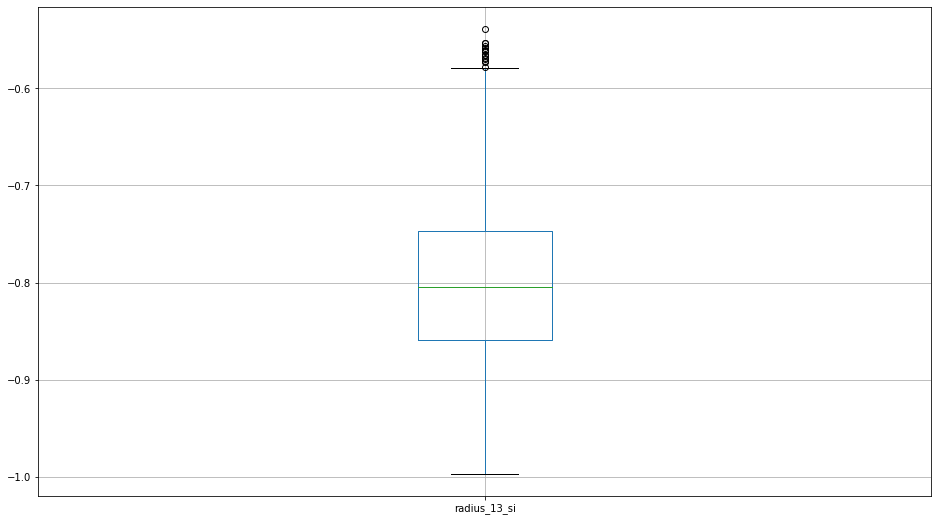

In [38]:
plot_boxplot(df_re, 'radius_13_si')